# Pilot Subjects Analysis

Dataset gathered from pilot subjects. All subjects were healthy adults. **TODO - ADD DESCRIPTION FOR PILOT SUBJECTS**

<img src="images/ddm_desc.jpeg" width="600">

Here, we use the `hddm` (Python) library$^1$ to model language-based decision making based on response-time & accuracy data from a binary forced-choice decision task. During each trial, subjects were presented with a digital image of an item (visual stimulus) and a verbal description (auditory stimulus). At the end of each trial, subjects were asked to indicate whether the two types of stimuli agreed (i.e. visual and auditory stimulus pointed to the same object) or were different (i.e. non-matching sound and image). Auditory and visual stimuli pairs fell under four distinct categories, as summarised below:  
- Condition 1 (**SS**): Same stimuli (see cat / hear cat)
- Condition 2 (**CP**): Phonologically congruent (see cat / hear hat)
- Condition 3 (**CS**): Semantically congruent (see cat / hear dog)
- Condition 4 (**US**): Unrelated stimuli (see house / hear cat)

In [2]:
"""
Environment setup
"""
%matplotlib inline
%cd ~/Programming/projects/language_decision/
import warnings; warnings.filterwarnings('ignore')
import hddm
import numpy as np
import matplotlib.pyplot as plt

/Users/celefthe/Programming/projects/language_decision


In [3]:
"""
Plot Drift Diffusion Model for pilot subjects data
"""

pilot_subjects = hddm.load_csv('data/pilot_clean.csv')

# Test if stimulus type affects drift rate
model = hddm.HDDM(pilot_subjects, depends_on={'v': 'stim'})
model.find_starting_values()
model.sample(6000, burn=20)

 [-----------------100%-----------------] 6000 of 6000 complete in 264.6 sec

## Convergence Checks

Before carrying on with analysing the output of the model, we need to check that the markov chains have properly converged. There's a number of ways to do this, which the authors of the `hddm` library recommend$^1$. We'll begin by visually inspecting the MCMC posterior plots. 

Plotting a
Plotting a_std
Plotting v(CP)
Plotting v(CS)
Plotting v(SS)
Plotting v(US)
Plotting v_std
Plotting t
Plotting t_std


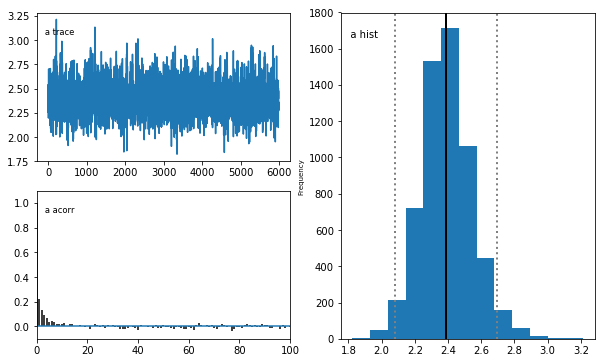

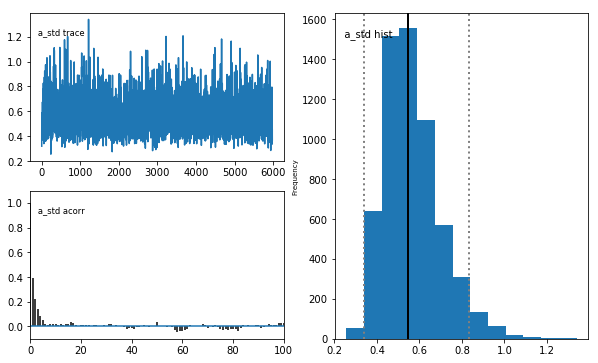

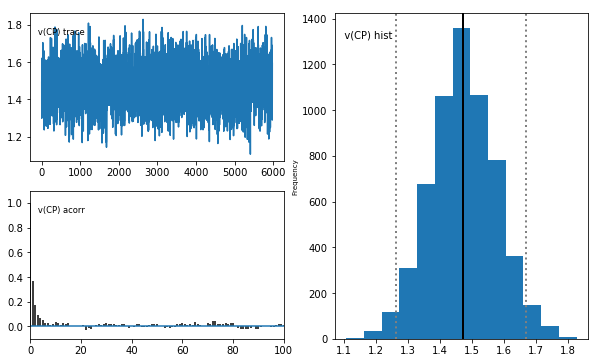

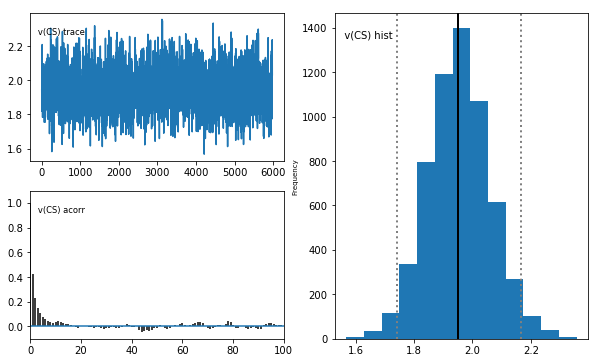

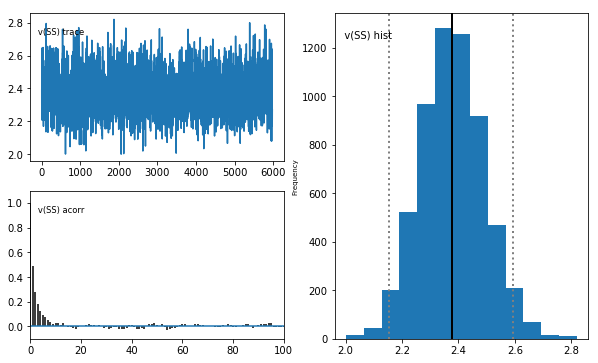

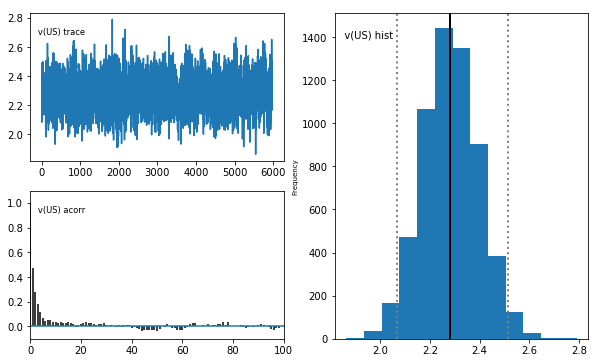

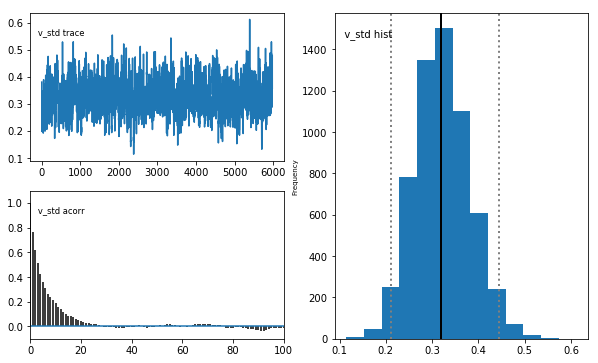

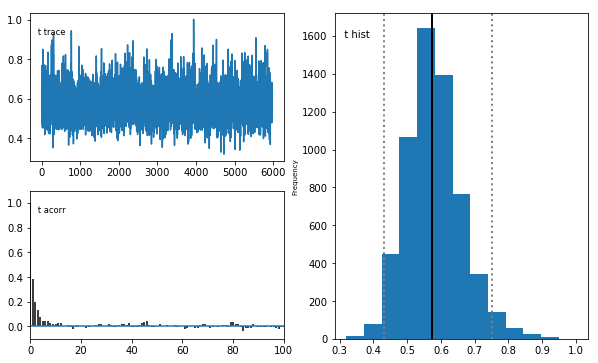

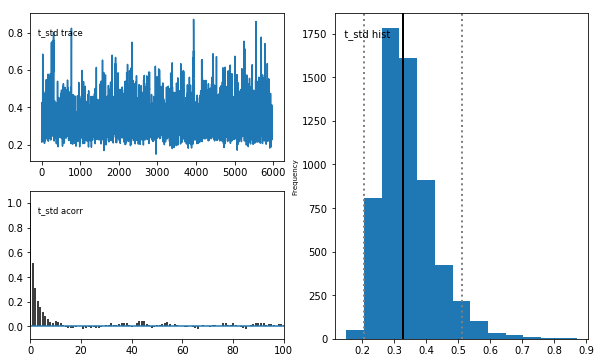

In [4]:
model.plot_posteriors()

## Dataset & Model Statistics

In [74]:
model.print_stats() # Dump statistics

                       mean        std       2.5q        25q        50q        75q     97.5q       mc err
a                   2.39628   0.153225    2.10876    2.29418    2.39143    2.49364   2.71529   0.00305992
a_std              0.565626   0.130216   0.363395    0.47293   0.545755   0.636935  0.880472   0.00272905
a_subj.17991        3.52348   0.241471     3.0698    3.36065    3.51155    3.67861   4.02537   0.00652452
a_subj.18288        2.37988   0.162983    2.08172    2.26526    2.37298    2.48644   2.72102   0.00415699
a_subj.18325        2.75334   0.237896    2.34441    2.58074    2.73353    2.90326   3.26729   0.00889081
a_subj.18333        2.28587   0.160049    1.99638    2.17342    2.27576    2.38924   2.62032   0.00429376
a_subj.18334        2.41846   0.243296    2.00547    2.25181    2.39514    2.55986   2.97359   0.00947567
a_subj.18350        1.63728   0.126992    1.41409    1.54858    1.62908    1.71498   1.91117   0.00380912
a_subj.18547        1.75425   0.111955    1.55

| Variable            | Mean (3 dp) | Standard Deviation (3 dp) | 
| ------------------- | ----------- | ------------------------- | 
| Threshold (a)       |    2.396    |           0.565           |
| SS Drift Rate (vSS) |    2.376    |           0.112           |
| CP Drift Rate (vCP) |    1.474    |           0.102           |
| CS Drift Rate (vCS) |    1.956    |           0.110           |
| US Drift Rate (vUS) |    2.285    |           0.109           |

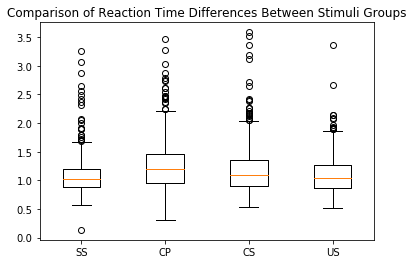

In [72]:
us = pilot_subjects.loc[pilot_subjects['stim'] == 'US']
ss = pilot_subjects.loc[pilot_subjects['stim'] == 'SS']
cp = pilot_subjects.loc[pilot_subjects['stim'] == 'CP']
cs = pilot_subjects.loc[pilot_subjects['stim'] == 'CS']

plt.boxplot([ss.rt.values, cp.rt.values, cs.rt.values, us.rt.values], 
            labels=('SS', 'CP', 'CS', 'US'),)
plt.title('Comparison of Reaction Time Differences Between Stimuli Groups')
plt.show()

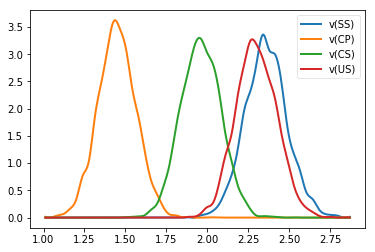

In [36]:
v_SS, v_CP, v_CS, v_US = model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([v_SS, v_CP, v_CS, v_US])

## Bias Analysis

In [21]:
model_bias = hddm.HDDM(pilot_subjects, depends_on={'v': 'stim', 'z': 'stim'}, bias=True)
model_bias.find_starting_values()
model_bias.sample(6000, burn=20)

 [-----------------100%-----------------] 6000 of 6000 complete in 443.8 sec

## Checking for Model Convergence

In [23]:
models = []
for i in range(5):
    m = hddm.HDDM(pilot_subjects, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(6000, burn=20)
    models.append(m)

hddm.analyze.gelman_rubin(models)

 [-----------------100%-----------------] 6000 of 6000 complete in 266.0 sec

{'a': 1.0000662857959119,
 'a_std': 0.99995997528757385,
 'a_subj.17991': 1.0003789053588501,
 'a_subj.18288': 1.0002624318926849,
 'a_subj.18325': 1.0015721827254036,
 'a_subj.18333': 1.0002418622987137,
 'a_subj.18334': 1.0003341705764808,
 'a_subj.18350': 1.0014503083071484,
 'a_subj.18547': 1.0006182620907456,
 'a_subj.18619': 1.0021192162799832,
 'a_subj.18864': 1.0004625991982046,
 'a_subj.18919': 1.0011214295536599,
 'a_subj.18977': 1.0010385734892839,
 'a_subj.18978': 1.0010660709786812,
 'a_subj.18979': 1.0000227118767715,
 'a_subj.18988': 1.0015271982184146,
 'a_subj.19686': 1.0005824065895916,
 'a_subj.19687': 1.0018232179819673,
 't': 1.0000929176517055,
 't_std': 1.0001607112834596,
 't_subj.17991': 1.0007635152350247,
 't_subj.18288': 0.99992820420660755,
 't_subj.18325': 1.0020203051878724,
 't_subj.18333': 1.000130578894787,
 't_subj.18334': 1.0001792761973167,
 't_subj.18350': 1.0017044872165706,
 't_subj.18547': 1.0005403904857069,
 't_subj.18619': 1.0018351072351313,

## Conclusions

## References

[1] Wiecki TV, Sofer I and Frank MJ (2013). HDDM: Hierarchical Bayesian estimation of the Drift-Diffusion Model in Python. Front. Neuroinform. 7:14. doi: 10.3389/fninf.2013.00014